## 1. Setup: Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.1


In [2]:
# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple Silicon GPU (MPS)


## 2. Load the Trained Model

In [3]:
# Define model architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load trained model
model = SimpleNN().to(device)
model.load_state_dict(torch.load('../models/mnist_model.pth'))
model.eval()  # Set to evaluation mode

print("✓ Model loaded successfully!")
print("✓ Model in evaluation mode")

✓ Model loaded successfully!
✓ Model in evaluation mode


## 3. Load Test Data for Examples

In [4]:
# Load test dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

print(f"Test set loaded: {len(test_dataset)} samples")

Test set loaded: 10000 samples


## 4. Create a Prediction Function

Let's create a reusable function for making predictions.

In [5]:
def predict_digit(model, image_tensor, device):
    """
    Make a prediction on a single image.
    
    Args:
        model: The trained neural network
        image_tensor: Input image as a tensor (1, 28, 28)
        device: Device to run inference on
    
    Returns:
        prediction: Predicted digit (0-9)
        probabilities: Probability distribution over all digits
        confidence: Confidence score for the prediction
    """
    with torch.no_grad():
        # Add batch dimension and move to device
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Forward pass
        output = model(image_tensor)
        
        # Get probabilities
        probabilities = F.softmax(output, dim=1)[0]
        
        # Get prediction
        prediction = output.argmax(dim=1).item()
        confidence = probabilities[prediction].item()
        
        return prediction, probabilities.cpu().numpy(), confidence

print("✓ Prediction function created!")

✓ Prediction function created!


## 5. Make a Single Prediction

Let's test our prediction function on a random image.

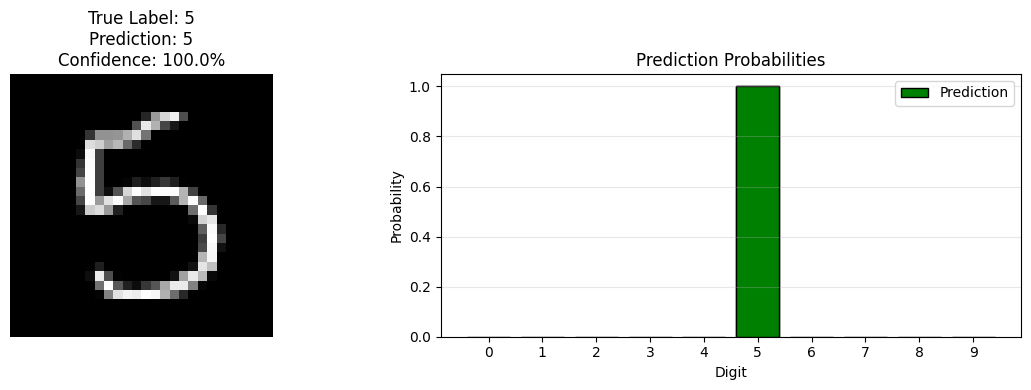


Prediction: 5
True label: 5
Correct: True

Probability breakdown:
  Digit 0:  0.00%
  Digit 1:  0.00%
  Digit 2:  0.00%
  Digit 3:  0.00%
  Digit 4:  0.00%
  Digit 5: 100.00%
  Digit 6:  0.00%
  Digit 7:  0.00%
  Digit 8:  0.00%
  Digit 9:  0.00%


In [6]:
# Get a random test image
idx = np.random.randint(0, len(test_dataset))
image, true_label = test_dataset[idx]

# Make prediction
prediction, probabilities, confidence = predict_digit(model, image, device)

# Display results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Show image
ax1.imshow(image.squeeze().numpy(), cmap='gray')
ax1.set_title(f'True Label: {true_label}\nPrediction: {prediction}\nConfidence: {confidence*100:.1f}%',
              fontsize=12)
ax1.axis('off')

# Show probability distribution
ax2.bar(range(10), probabilities, color='steelblue', edgecolor='black')
ax2.bar(prediction, probabilities[prediction], color='green', edgecolor='black', label='Prediction')
ax2.set_xlabel('Digit')
ax2.set_ylabel('Probability')
ax2.set_title('Prediction Probabilities')
ax2.set_xticks(range(10))
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrediction: {prediction}")
print(f"True label: {true_label}")
print(f"Correct: {prediction == true_label}")
print(f"\nProbability breakdown:")
for digit in range(10):
    print(f"  Digit {digit}: {probabilities[digit]*100:5.2f}%")

## 6. Batch Predictions with Visualization

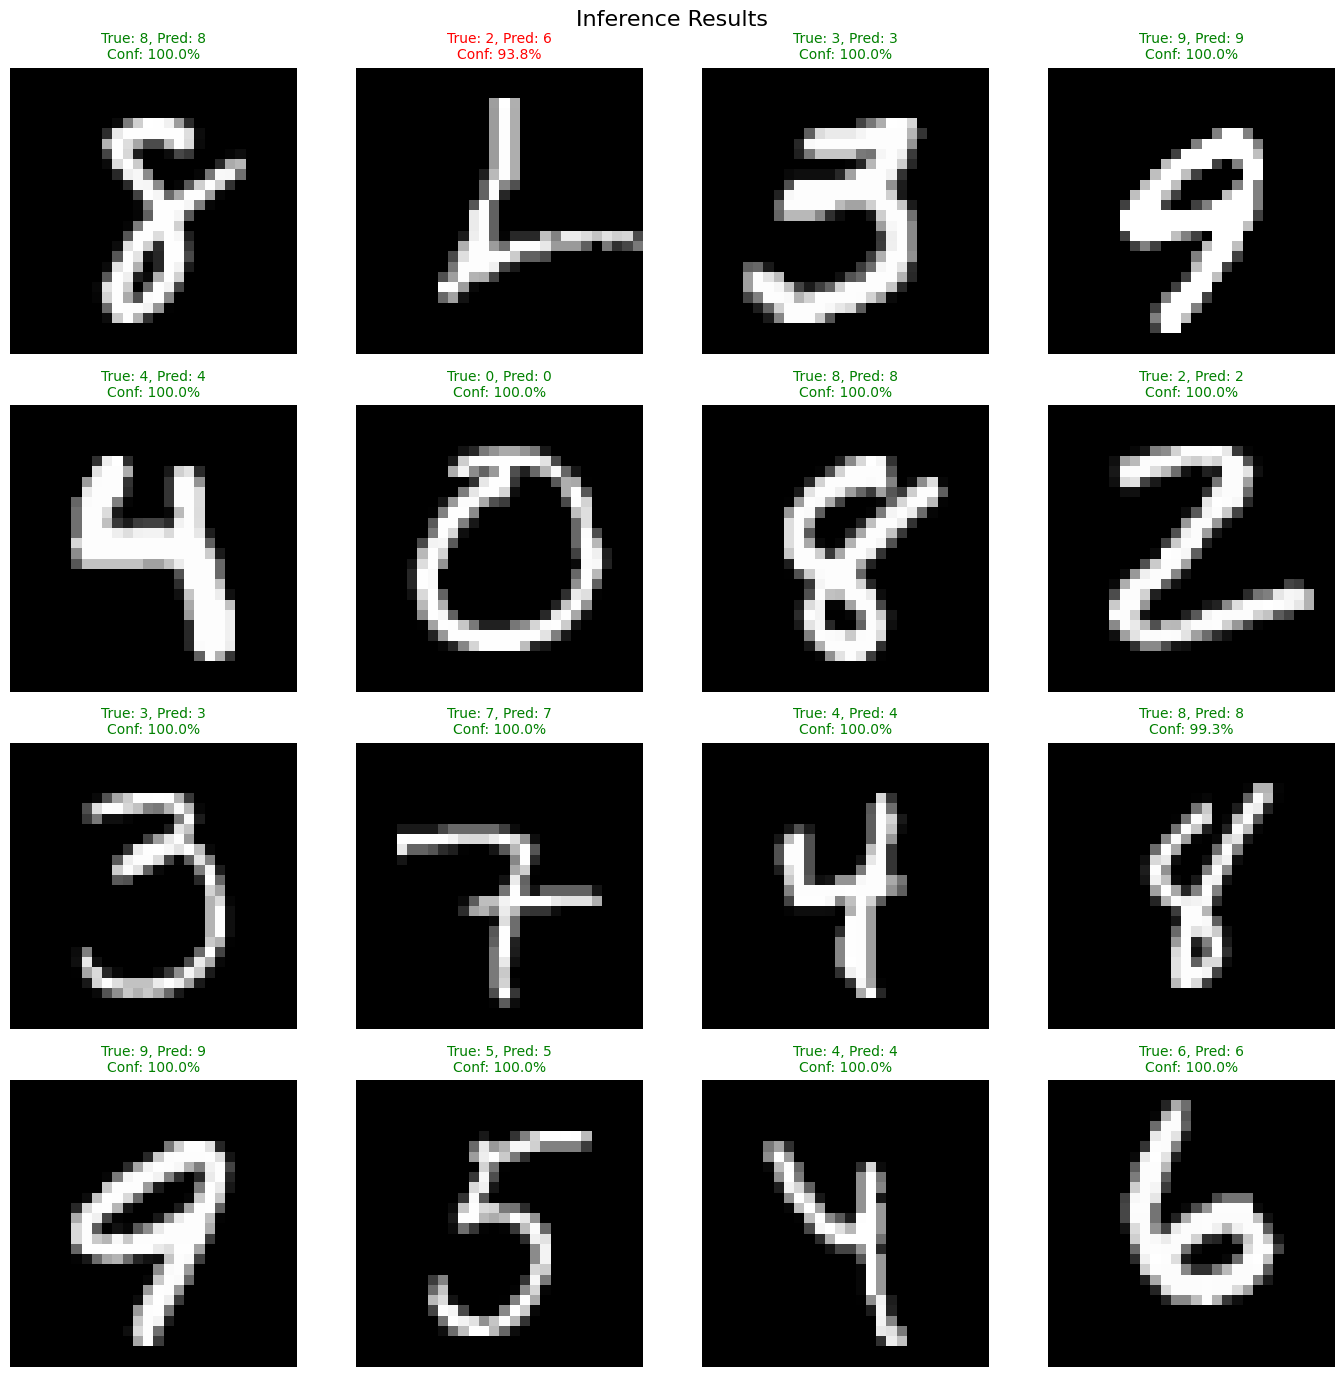

In [7]:
# Select random samples
num_samples = 16
random_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(14, 14))
fig.suptitle('Inference Results', fontsize=16)

for idx, ax in enumerate(axes.flat):
    # Get image
    image, true_label = test_dataset[random_indices[idx]]
    
    # Make prediction
    prediction, probabilities, confidence = predict_digit(model, image, device)
    
    # Display
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    
    # Color based on correctness
    color = 'green' if prediction == true_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {prediction}\nConf: {confidence*100:.1f}%',
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 7. Analyze Prediction Confidence

Let's look at high-confidence and low-confidence predictions.

In [8]:
# Make predictions on many samples and collect confidences
sample_size = 500
confidences = []
predictions_list = []
true_labels_list = []
images_list = []

for i in range(sample_size):
    image, true_label = test_dataset[i]
    prediction, _, confidence = predict_digit(model, image, device)
    
    confidences.append(confidence)
    predictions_list.append(prediction)
    true_labels_list.append(true_label)
    images_list.append(image)

confidences = np.array(confidences)
predictions_list = np.array(predictions_list)
true_labels_list = np.array(true_labels_list)

# Find indices of highest and lowest confidence
high_conf_idx = np.argsort(confidences)[-8:]  # Top 8
low_conf_idx = np.argsort(confidences)[:8]    # Bottom 8

print(f"Highest confidence: {confidences[high_conf_idx[-1]]*100:.2f}%")
print(f"Lowest confidence: {confidences[low_conf_idx[0]]*100:.2f}%")

Highest confidence: 100.00%
Lowest confidence: 49.49%


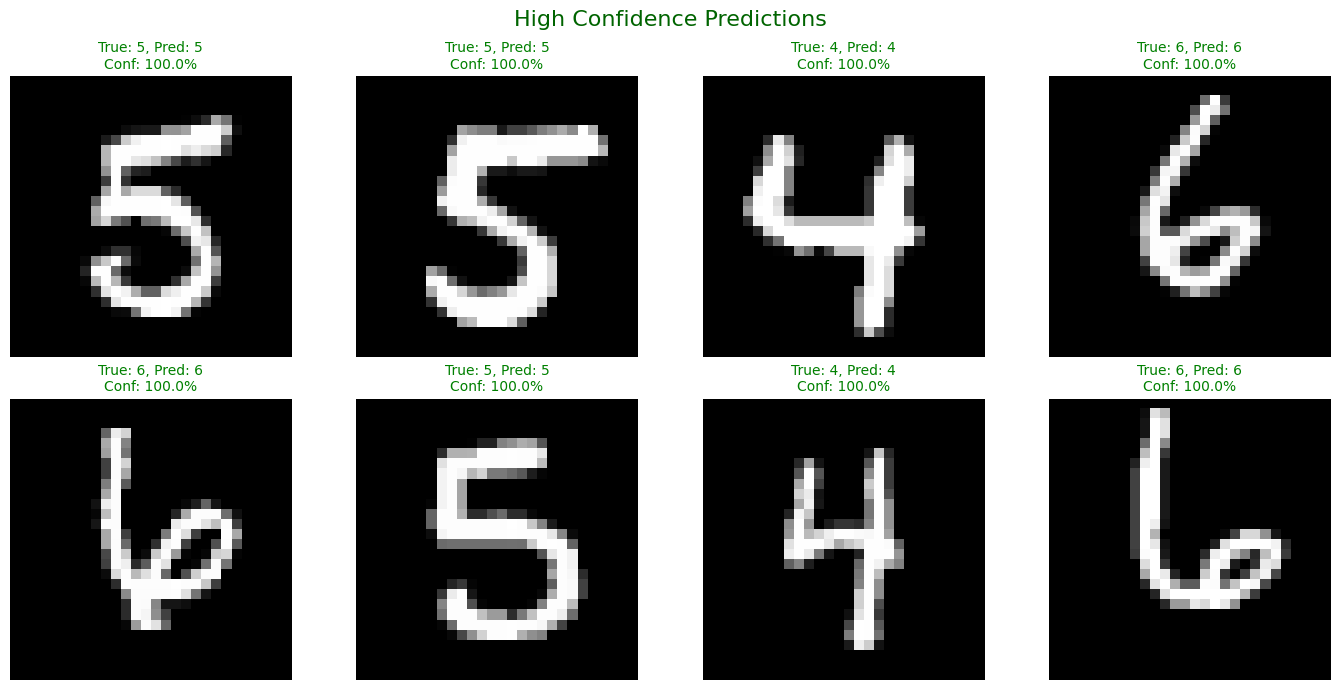

In [9]:
# Visualize high confidence predictions
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('High Confidence Predictions', fontsize=16, color='darkgreen')

for idx, ax in enumerate(axes.flat):
    img_idx = high_conf_idx[idx]
    image = images_list[img_idx]
    true_label = true_labels_list[img_idx]
    prediction = predictions_list[img_idx]
    confidence = confidences[img_idx]
    
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    color = 'green' if prediction == true_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {prediction}\nConf: {confidence*100:.1f}%',
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

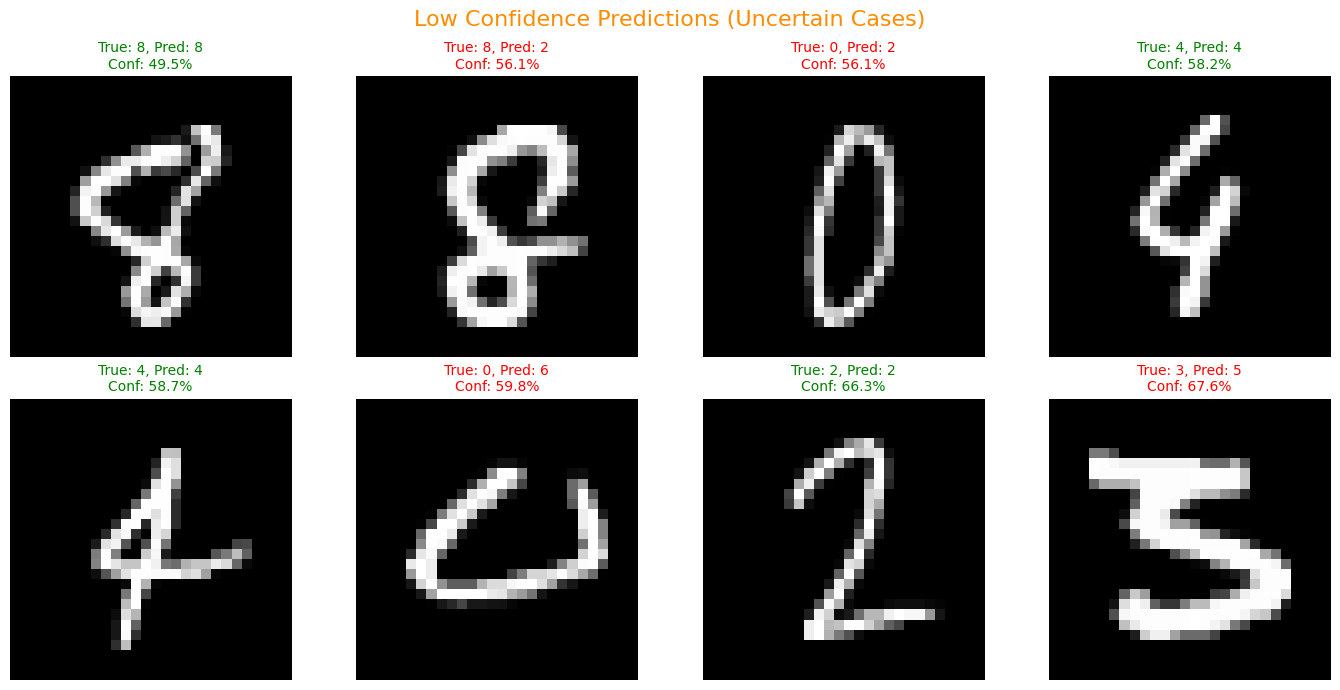


Note: Low confidence often indicates:
  - Ambiguous handwriting
  - Unusual digit shapes
  - Edge cases the model hasn't seen much


In [10]:
# Visualize low confidence predictions
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Low Confidence Predictions (Uncertain Cases)', fontsize=16, color='darkorange')

for idx, ax in enumerate(axes.flat):
    img_idx = low_conf_idx[idx]
    image = images_list[img_idx]
    true_label = true_labels_list[img_idx]
    prediction = predictions_list[img_idx]
    confidence = confidences[img_idx]
    
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    color = 'green' if prediction == true_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {prediction}\nConf: {confidence*100:.1f}%',
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\nNote: Low confidence often indicates:")
print("  - Ambiguous handwriting")
print("  - Unusual digit shapes")
print("  - Edge cases the model hasn't seen much")

## 8. Interactive Prediction Function

Create a comprehensive function you can use in production.

In [11]:
def predict_and_visualize(model, image_tensor, true_label=None, device='cpu'):
    """
    Make a prediction and create a detailed visualization.
    """
    # Make prediction
    prediction, probabilities, confidence = predict_digit(model, image_tensor, device)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Show image
    ax1.imshow(image_tensor.squeeze().numpy(), cmap='gray')
    title = f'Prediction: {prediction}\nConfidence: {confidence*100:.1f}%'
    if true_label is not None:
        title = f'True: {true_label}, {title}'
        color = 'green' if prediction == true_label else 'red'
    else:
        color = 'black'
    ax1.set_title(title, color=color, fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Show probabilities
    colors = ['green' if i == prediction else 'steelblue' for i in range(10)]
    ax2.bar(range(10), probabilities, color=colors, edgecolor='black')
    ax2.set_xlabel('Digit', fontsize=12)
    ax2.set_ylabel('Probability', fontsize=12)
    ax2.set_title('Class Probabilities', fontsize=14)
    ax2.set_xticks(range(10))
    ax2.grid(axis='y', alpha=0.3)
    
    # Add percentage labels on bars
    for i, prob in enumerate(probabilities):
        if prob > 0.05:  # Only show if > 5%
            ax2.text(i, prob + 0.02, f'{prob*100:.1f}%', 
                    ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nPrediction Results:")
    print("=" * 50)
    print(f"Predicted digit: {prediction}")
    if true_label is not None:
        print(f"True label: {true_label}")
        print(f"Correct: {'✓' if prediction == true_label else '✗'}")
    print(f"Confidence: {confidence*100:.2f}%")
    print("\nTop 3 predictions:")
    top3_idx = np.argsort(probabilities)[::-1][:3]
    for i, idx in enumerate(top3_idx, 1):
        print(f"  {i}. Digit {idx}: {probabilities[idx]*100:.2f}%")
    
    return prediction, probabilities, confidence

print("✓ Comprehensive prediction function created!")

✓ Comprehensive prediction function created!


## 9. Test the Interactive Function

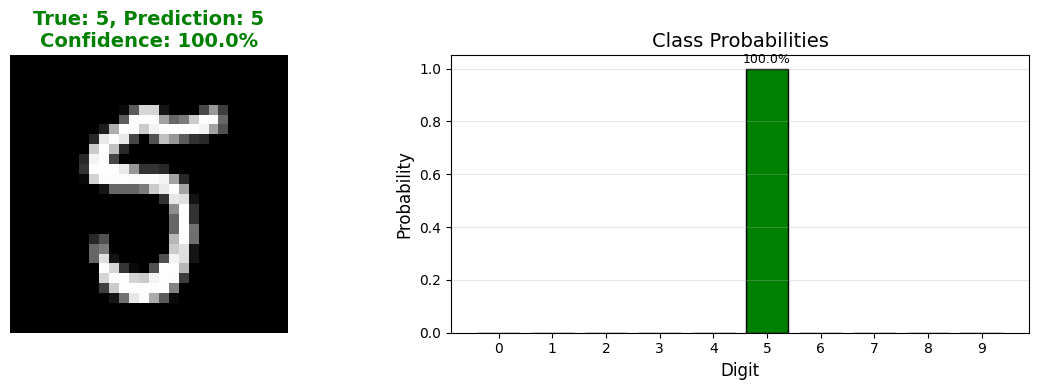


Prediction Results:
Predicted digit: 5
True label: 5
Correct: ✓
Confidence: 99.99%

Top 3 predictions:
  1. Digit 5: 99.99%
  2. Digit 9: 0.01%
  3. Digit 3: 0.00%


In [12]:
# Try it on a random sample
idx = np.random.randint(0, len(test_dataset))
image, true_label = test_dataset[idx]

prediction, probs, conf = predict_and_visualize(model, image, true_label, device)

## 10. Predict on Each Digit (0-9)

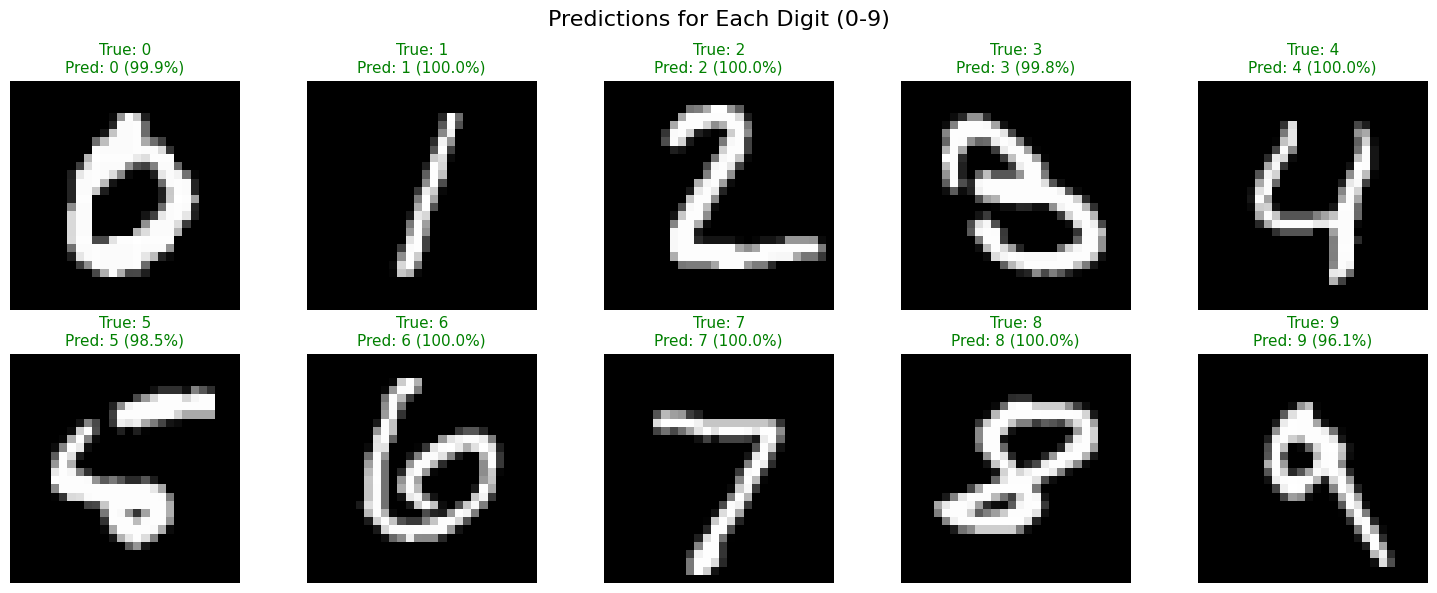

In [13]:
# Find one example of each digit and predict
digit_examples = {}

for image, label in test_dataset:
    if label not in digit_examples:
        digit_examples[label] = image
    if len(digit_examples) == 10:
        break

# Make predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Predictions for Each Digit (0-9)', fontsize=16)

for digit in range(10):
    ax = axes[digit // 5, digit % 5]
    image = digit_examples[digit]
    
    prediction, probabilities, confidence = predict_digit(model, image, device)
    
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    color = 'green' if prediction == digit else 'red'
    ax.set_title(f'True: {digit}\nPred: {prediction} ({confidence*100:.1f}%)',
                 color=color, fontsize=11)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 11. Production-Ready Inference Function

Here's a clean function you could use in a real application.

In [14]:
class DigitClassifier:
    """
    A simple wrapper class for MNIST digit classification.
    """
    def __init__(self, model_path, device='cpu'):
        self.device = torch.device(device)
        
        # Load model
        self.model = SimpleNN().to(self.device)
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()
        
        print(f"✓ Model loaded from {model_path}")
        print(f"✓ Using device: {self.device}")
    
    def predict(self, image_tensor):
        """
        Predict digit from image tensor.
        
        Returns:
            dict with 'digit', 'confidence', and 'probabilities'
        """
        with torch.no_grad():
            image_tensor = image_tensor.unsqueeze(0).to(self.device)
            output = self.model(image_tensor)
            probabilities = F.softmax(output, dim=1)[0]
            prediction = output.argmax(dim=1).item()
            confidence = probabilities[prediction].item()
            
            return {
                'digit': prediction,
                'confidence': confidence,
                'probabilities': probabilities.cpu().numpy()
            }
    
    def predict_batch(self, image_tensors):
        """
        Predict multiple images at once.
        """
        results = []
        for img in image_tensors:
            results.append(self.predict(img))
        return results

# Create classifier instance
classifier = DigitClassifier('../models/mnist_model.pth', device=device)

print("\n✓ Classifier ready for use!")

✓ Model loaded from ../models/mnist_model.pth
✓ Using device: mps

✓ Classifier ready for use!


In [15]:
# Test the classifier
image, true_label = test_dataset[42]  # Random example

result = classifier.predict(image)

print("Classifier Result:")
print("=" * 40)
print(f"Predicted digit: {result['digit']}")
print(f"Confidence: {result['confidence']*100:.2f}%")
print(f"True label: {true_label}")
print(f"Correct: {'Yes ✓' if result['digit'] == true_label else 'No ✗'}")

Classifier Result:
Predicted digit: 4
Confidence: 100.00%
True label: 4
Correct: Yes ✓


## 12. Summary

Congratulations! You've completed Exercise 6 and the entire tutorial! You now know:

✅ How to load a saved model for inference

✅ How to make predictions on single images

✅ How to interpret model outputs and confidence scores

✅ How to visualize predictions with probability distributions

✅ How to identify high and low confidence predictions

✅ How to create production-ready prediction functions

✅ How to wrap models in reusable classes

### Key Concepts for Inference

1. **Model Evaluation Mode**: Always use `model.eval()` for inference
2. **No Gradients**: Use `torch.no_grad()` to save memory
3. **Softmax for Probabilities**: Convert raw outputs to probabilities
4. **Confidence**: The probability of the predicted class
5. **Uncertainty**: Low confidence indicates uncertain predictions

### What You've Accomplished

Throughout this tutorial series, you've:
1. ✅ Set up a PyTorch development environment
2. ✅ Learned PyTorch tensor basics
3. ✅ Loaded and explored the MNIST dataset
4. ✅ Built a neural network from scratch
5. ✅ Trained the model to ~97-98% accuracy
6. ✅ Evaluated model performance with detailed metrics
7. ✅ Created a production-ready inference system

### Next Steps

To continue learning, try:
- **Improve the model**: Add more layers, try different architectures (CNNs)
- **Data augmentation**: Rotate, scale, or distort images during training
- **Hyperparameter tuning**: Experiment with learning rates, batch sizes
- **Other datasets**: Try Fashion-MNIST, CIFAR-10, or your own data
- **Save as ONNX**: Export for deployment in other frameworks
- **Build an app**: Create a web or mobile app using your model

### Congratulations! 🎉

You've successfully learned the fundamentals of training and deploying neural networks!

The skills you've learned here apply to much more complex problems - the workflow is the same:
1. Load data
2. Build model
3. Train
4. Evaluate
5. Deploy

Keep learning and building! 🚀